# Natural Language Processing with Disaster Tweets

University of Colorado Boulder - DTSA 5511 Week 4

## 1. Description

Twitter is a major platform for sharing news and staying connected, especially during disasters. People often post about emergencies in real time, which can be incredibly helpful for first responders and disaster relief teams trying to assess the situation quickly.

However, detecting real disaster-related tweets is not straightforward. Many tweets include words like “fire,” “explosion,” or “flood,” but use them figuratively — for example, describing a party as “lit” or a performance as a “disaster.” These kinds of posts create a lot of noise, making it difficult to automatically identify urgent, real-world events.

The goal of this project is to train a model that can tell whether a tweet is about a real disaster or just using dramatic language. I’m using NLP techniques to clean up the tweets and then training a GRU-based neural network to spot patterns that separate actual emergencies from, well… exaggerated tweets about bad dates or Monday mornings.

---

### Dataset Summary

The dataset is provided by Kaggle and includes both training and test files:

**Training Set**
- **File**: `train.csv`
- **Rows**: 7,613 tweets
- **Columns**: 5
  - `id`: Unique identifier for the tweet
  - `keyword`: Disaster-related keyword (e.g., “flooding,” “earthquake”) – may be missing
  - `location`: Tweet location – noisy and often missing
  - `text`: The full tweet content (main input for modeling)
  - `target`: Binary label — `1` if the tweet is about a real disaster, `0` otherwise

**Test Set**
- **File**: `test.csv`
- **Rows**: 3,263 tweets
- **Columns**: 4 (same as training data but without `target`)

---

### Model Pipeline Overview

In this notebook, I:
- Explore and visualize the dataset to understand class distribution, tweet lengths, and keyword patterns
- Clean the tweet text by removing links, mentions, hashtags, emojis, and extra punctuation
- Apply tokenization and padding to convert text into fixed-length numeric sequences
- Build and train a GRU-based neural network using an embedding layer and dropout for regularization
- Evaluate the model using accuracy, F1 score, confusion matrix, and classification report
- Tune hyperparameters (embedding size, GRU units, dropout) to find the best model
- Generate predictions on the test set and prepare the final submission file

By the end of the project, the model should be able to identify disaster-related tweets with strong performance and generalize well to unseen tweets.


### Import Modules

In [1]:
# Standard libraries
import os
import re
import warnings

# Scientific computing and data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Deep learning - TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Natural language processing - spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# random seed for reproducibility
np.random.seed(22)
tf.random.set_seed(22)

### Load Datasets

In [3]:
# Load the train dataset
train_df = pd.read_csv(r'C:\Users\Saskia May\Downloads\nlp-getting-started\train.csv')

train_df.info()
train_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
1467,2115,catastrophe,Florida,@deb117 7/30 that catastrophe man opens school...,0
6453,9232,suicide%20bombing,NaN,meek mill should join isis since he loves suic...,0
5698,8131,rescued,Ireland,Three beached whales rescued in Kerry - http:/...,1
5769,8236,riot,Seattle,Southeast Dirt Riot Series Crowns Champions: ...,0
6853,9822,trauma,NaN,Hiroshima: They told me to paint my story: Eig...,1
3446,4924,exploded,Australia,Junko was 13 years old when the atomic bomb ex...,1
4042,5741,forest%20fires,"alberta, canada",@gilmanrocks7 wow. Where is this? For the rest...,1
6264,8949,storm,"Chicago, IL",How to prepare your #property for a #storm:\n\...,1
5955,8506,screaming,rio de janeiro | brazil,SCREAMING @MariahCarey @ArianaGrande http://t....,0
3431,4906,explode,NaN,My head is gonna explode,0


In [4]:
# Load the test dataset
test_df = pd.read_csv(r'C:\Users\Saskia May\Downloads\nlp-getting-started\test.csv')

test_df.info()
test_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
2429,8117,rescued,"Burnley, Lancashire",British trekkers rescued amid flash floods in ...
3030,10007,tsunami,http://t.co/mOY6lmu,Help support the victims of the Japanese Earth...
3019,9968,tsunami,NaN,TheDIYHacks: RT Illusionimagess: A tsunami clo...
2210,7388,obliterate,NaN,#dating Absolute Approaching: Unique 21-day co...
503,1642,bombing,London,What it was like to survive the atomic bombing...
1731,5844,hailstorm,North East America,Boston yesterday after an intense hailstorm. P...
371,1192,blizzard,Sunny Florida,Check out the #new #ebook on #sale by #TimZak ...
2267,7562,outbreak,NaN,Families to sue over Legionnaires: More than 4...
2173,7271,nuclear%20disaster,Stah-koomi-tapii-akii,Rare photographs show the nightmare aftermath ...
2580,8601,seismic,Malta; Gozo,The time for small steps has long been over. W...


## 2. Exploratory Data Analysis

### Class Distribution

Before diving into modeling, let’s take a quick look at the class distribution. The target variable `target` has two categories:

- **0**: Non-disaster tweet  
- **1**: Disaster-related tweet

There are more non-disaster tweets than disaster ones. Not surprising — people tweet a lot about “explosive performances” or “killer pizza” that have nothing to do with real emergencies.

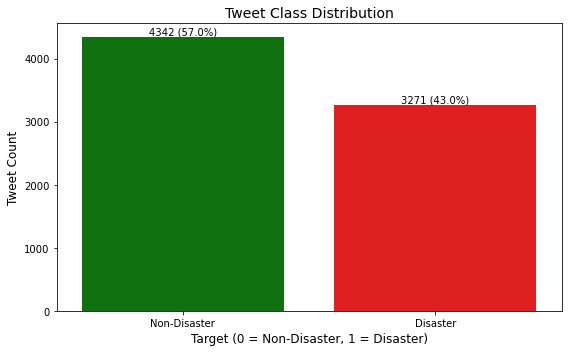

In [5]:
# Class Distribution Plot with Counts and Percentages
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='target', data=train_df, palette={0: 'green', 1: 'red'})

# Title and Axis Labels
plt.title('Tweet Class Distribution', fontsize=14)
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)', fontsize=12)
plt.ylabel('Tweet Count', fontsize=12)
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'], fontsize=10)

# Annotate counts and percentages
total = len(train_df)
for p in ax.patches:
    count = int(p.get_height())
    percentage = count / total * 100
    ax.annotate(f'{count} ({percentage:.1f}%)',
                xy=(p.get_x() + p.get_width() / 2, count),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Tweet Length (words) Distribution

Each tweet in the dataset was analyzed for its length, measured by the number of words it contains. A new feature called `tweet_length` was created by splitting the tweet text on spaces and counting the number of resulting tokens.

The plot below displays the distribution of tweet lengths. It includes a histogram showing the frequency of different word counts and a kernel density estimate (KDE) to visualize the underlying probability distribution.

Most tweets are between 10 and 20 words long. A smaller number of tweets are significantly longer, which results in a right-skewed distribution.

Understanding tweet length helps inform decisions for text preprocessing, such as setting an appropriate maximum sequence length when padding or truncating sequences for neural network input.

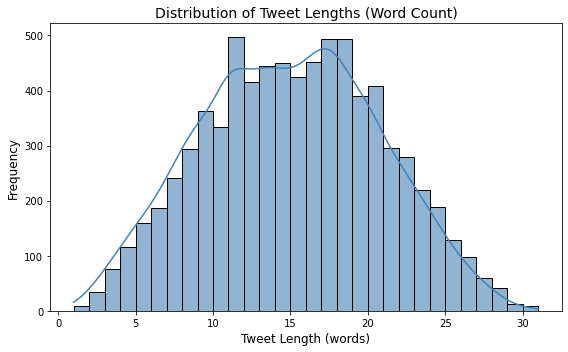

In [6]:
# Calculate tweet length in words
train_df['tweet_length_words'] = train_df['text'].apply(lambda text: len(text.split()))

# Plot the distribution of tweet lengths
plt.figure(figsize=(8, 5))
sns.histplot(train_df['tweet_length_words'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.6)

# Title and labels
plt.title('Distribution of Tweet Lengths (Word Count)', fontsize=14)
plt.xlabel('Tweet Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

### Tweet Length (characters) Distribution by Class

Each tweet in the dataset was analyzed for its length in characters. The resulting values were stored in a column called `text_length`.

The plot below shows the distribution of tweet lengths for both disaster and non-disaster tweets. A histogram and kernel density estimate (KDE) were used to visualize the frequency and underlying distribution of character counts.

The `target` variable was used as a hue to separate the two classes:
- Tweets with `target = 0` (non-disaster) are shown in green.
- Tweets with `target = 1` (disaster) are shown in red.

The legend was manually updated after rendering to correctly label each class without disrupting the color mapping.

The distribution indicates that non-disaster tweets tend to have a sharp peak at specific lengths, while disaster tweets follow a slightly more dispersed pattern. These differences in tweet length may provide useful signals for distinguishing between the two classes during model training.

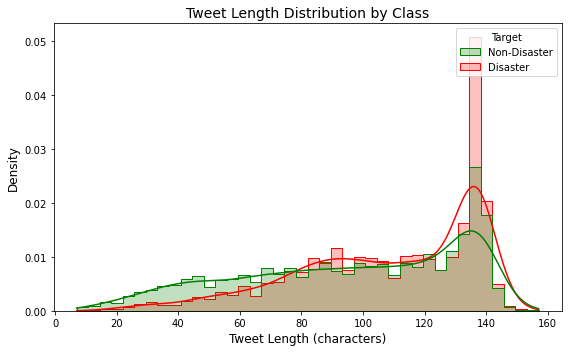

In [7]:
# Calculate tweet length in characters
train_df['text_length_char'] = train_df['text'].apply(len)

# KDE + Histogram by Class
plt.figure(figsize=(8, 5))
ax = sns.histplot(
    data=train_df,
    x='text_length_char',
    hue='target',
    kde=True,
    bins=40,
    palette={0: 'green', 1: 'red'},
    element='step',
    stat='density',
    common_norm=False
)

# Fix legend labels AFTER plot is drawn
legend = ax.get_legend()
legend.set_title('Target')
legend_labels = legend.get_texts()

# Manually relabel: assumes order [0, 1]
legend_labels[0].set_text('Non-Disaster')
legend_labels[1].set_text('Disaster')

plt.title('Tweet Length Distribution by Class', fontsize=14)
plt.xlabel('Tweet Length (characters)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()

### Top 20 Keywords by Tweet Type

The bar chart below displays the 20 most frequent keywords in the training dataset, grouped by tweet type: non-disaster (green) and disaster (red).

Each keyword appears in both classes to varying degrees, indicating that disaster-related terms are not exclusive to tweets about real disasters. For example, words like "wrecked", "explosion", and "earthquake" are often used in figurative or exaggerated contexts.

This highlights a key challenge of the task: identifying the intent behind tweets that contain disaster-related words. The plot also reflects class imbalance for several keywords, where one class dominates the other. This insight is useful for feature engineering and understanding potential bias in the dataset.


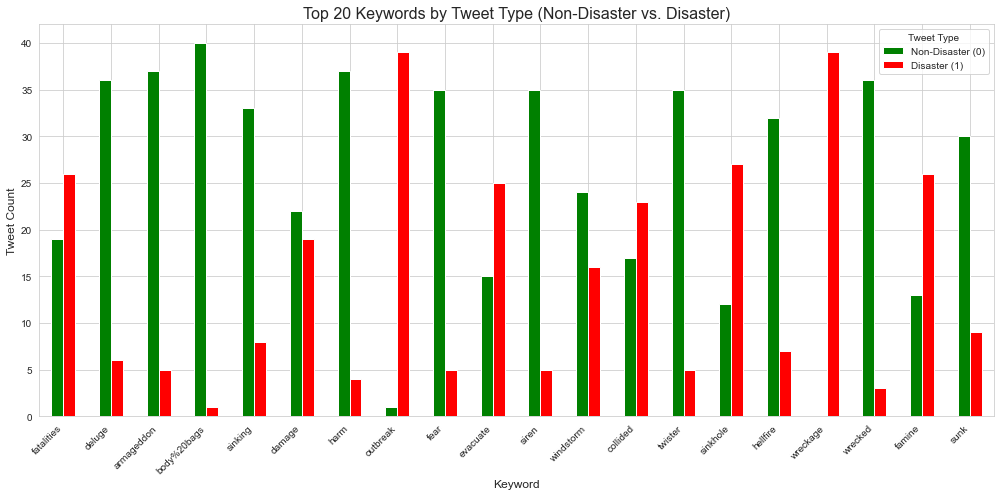

Total unique keywords (including NaN): 221


In [8]:
# Ensure Seaborn style for better visuals
sns.set_style("whitegrid")

# Group by 'keyword' and 'target', then reshape with unstack
keyword_target_counts = train_df.groupby(['keyword', 'target']).size().unstack(fill_value=0)

# Optional: Rename 'unknown' if missing keywords are present
if train_df['keyword'].isna().any():
    keyword_target_counts.index = keyword_target_counts.index.fillna('NaN')

# Ensure consistent column order: 0 = Non-Disaster, 1 = Disaster
keyword_target_counts = keyword_target_counts[[0, 1]]

# Get top 20 keywords by total frequency
top_keywords = keyword_target_counts.sum(axis=1).sort_values(ascending=False).head(20).index
plot_data = keyword_target_counts.loc[top_keywords]

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
plot_data.plot(kind='bar', color=['green', 'red'], ax=ax)

# Title and labels
plt.title('Top 20 Keywords by Tweet Type (Non-Disaster vs. Disaster)', fontsize=16)
plt.xlabel('Keyword', fontsize=12)
plt.ylabel('Tweet Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(['Non-Disaster (0)', 'Disaster (1)'], title='Tweet Type', fontsize=10)

plt.tight_layout()
plt.show()

# Print total unique keywords for context
print(f"Total unique keywords (including NaN): {len(keyword_target_counts)}")

## 3. Data Cleaning Procedure

Before feeding tweets into the model, I wrote a function to clean them up — removing links, mentions, emojis, and weird punctuation. I also lowercase everything and optionally lemmatize for better analysis. Here's what the function looks like:

1. **Remove URLs**  
   All web links (e.g., `http://...`, `www...`) are removed to eliminate irrelevant external content.

2. **Remove Hashtag Symbols**  
   The `#` symbol is removed to preserve the keyword but discard the symbol itself (e.g., `#earthquake` becomes `earthquake`).

3. **Remove Mentions**  
   Twitter mentions (e.g., `@user`) are removed to eliminate user references that do not contribute meaningfully to classification.

4. **Remove Special Characters and Punctuation**  
   All non-alphanumeric characters (except whitespace) are removed to simplify the text.

5. **Remove Emoticons**  
   Common emoticons like `:)`, `:(`, `:D`, `:P` are removed to reduce informal noise in the data.

6. **Convert to Lowercase**  
   The text is converted to lowercase to normalize the vocabulary and reduce case-related duplication.

7. **Remove Extra Whitespace**  
   Multiple spaces are collapsed into a single space, and any leading/trailing spaces are removed.

8. **Optional Lemmatization (for EDA only)**  
   When `for_eda=True`, the cleaned tweet is tokenized using spaCy. Tokens are lemmatized, stopwords are removed, and only alphabetic tokens with more than one character are kept. The result is a simplified and normalized version of the tweet for exploratory analysis.

In [9]:
def clean_tweet(tweet, for_eda=False, for_vector=False):
    if not isinstance(tweet, str):
        return ""
    # Lowercase the text
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet)
    # Remove mentions
    tweet = re.sub(r'\@\w+', '', tweet)
    # Remove hashtags completely (e.g., #disaster → '')
    tweet = re.sub(r'#\w+', '', tweet)
    # Remove special characters and punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Remove emoticons (text-based emojis)
    tweet = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', tweet)
    # Remove non-ASCII characters (e.g., emojis, accented characters)
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    # Normalize whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    # Optional: Tokenize, lemmatize, remove stopwords, etc.
    if for_eda:
        cleaned_tokens = [
            token.lemma_ for token in nlp(tweet)
            if not token.is_stop and token.is_alpha and len(token) > 1
        ]
        tweet = " ".join(cleaned_tokens)
    return tweet

#### 📌 Example

**Original Tweet:**  

In [10]:
train_df['text'][31]

'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

**Cleaned Tweet (for EDA):**

In [11]:
test_df['cleaned_tweet'] = test_df['text'].apply(clean_tweet, args=[True])

train_df['cleaned_tweet'] = train_df['text'].apply(clean_tweet, args=[True])
train_df['cleaned_tweet'][31]

'wholesale market ablaze'

### Tokenize and Pad Tweets

Before training the neural network, the cleaned tweet text must be transformed into a numerical format. In this step, I use the Keras `Tokenizer` to convert each tweet into a sequence of integers, where each integer represents a word's rank in the vocabulary based on frequency.

I limit the vocabulary to the top **15,000 most frequent words** in the dataset to reduce complexity and focus on meaningful tokens. Each tweet is then padded or truncated to a fixed length of **100 tokens** to ensure uniform input dimensions, which is required for feeding the data into a sequential neural network model.

Finally, I extract the target variable, renamed here as `disaster_flag`, which serves as the label indicating whether a tweet refers to a real disaster (`1`) or not (`0`).


In [12]:
# Set vocabulary size and max sequence length
vocab_size = 15000      # Only keep the top 15,000 most common words
sequence_length = 100   # All tweet sequences will be padded/truncated to 100 tokens

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)

# Fit the tokenizer on the cleaned training tweets (build word index)
tokenizer.fit_on_texts(train_df['cleaned_tweet'])

# Convert tweets into sequences of word IDs
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_tweet'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_tweet'])

# Pad sequences so they all have the same length
X_train = pad_sequences(train_sequences, maxlen=sequence_length, padding='pre')
X_test = pad_sequences(test_sequences, maxlen=sequence_length, padding='pre')

# Extract target labels
y_train = train_df['target'].values

### Split Data into Training and Validation Sets

Before training the model, I split the padded tweet data into training and validation sets using an 80/20 ratio. Stratified sampling is applied to maintain the same proportion of disaster vs. non-disaster tweets in both sets, which is important for balanced evaluation.

I also define a utility function to convert NumPy arrays into `tf.data.Dataset` objects. This format is more efficient for training deep learning models in TensorFlow because it supports optimized data loading, automatic batching, and prefetching.

In the training dataset, I apply shuffling to ensure the model doesn't learn any sequence-specific bias. The validation dataset is not shuffled to maintain consistency during evaluation.

In [13]:
# Set the batch size for model training
batch_size = 64

# Split the padded training data into training and validation sets (80/20 split)
# Stratify ensures both sets have a similar distribution of the target labels
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

# Function to create a TensorFlow dataset for efficient input pipeline
def create_tf_dataset(features, labels, batch_size=64, shuffle=True):
    """
    Converts input features and labels into a tf.data.Dataset object.
    Enables shuffling, batching, and prefetching for performance.
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

# Create the training and validation datasets
train_dataset = create_tf_dataset(X_train_split, y_train_split, batch_size, shuffle=True)
val_dataset = create_tf_dataset(X_val, y_val, batch_size, shuffle=False)

## 5. Build Model

For this binary text classification task, I use a GRU (Gated Recurrent Unit) neural network. GRUs are effective for working with sequence data like tweets because they can capture patterns over time steps while being more computationally efficient than LSTMs.

The model architecture consists of the following layers:

- **Input Layer**: Accepts a fixed-length padded sequence of integers representing tokenized words (100 tokens per tweet).
- **Embedding Layer**: Converts each word ID into a dense vector. These embeddings are learned during training and help the model understand semantic relationships between words.
- **SpatialDropout1D**: Randomly drops entire word vectors during training, which helps prevent overfitting and improves generalization.
- **GRU Layer**: Captures sequential and contextual patterns in the tweet data. GRUs are designed to handle dependencies over time without the complexity of LSTMs.
- **Dense Output Layer**: A single neuron with a sigmoid activation outputs a probability between 0 and 1, representing the likelihood that the tweet is about a real disaster.

The model is compiled using:
- **Loss Function**: `binary_crossentropy`, which is standard for binary classification tasks.
- **Optimizer**: `Adam`, a fast and adaptive learning rate optimizer.
- **Metric**: `accuracy`, to monitor performance during training and validation.

---

### Why Use Word Embeddings?

Word embeddings transform text into compact numeric vectors that capture semantic meaning. Unlike one-hot encoding, which is sparse and doesn't capture context, embeddings group similar words close together in vector space.

**Methods of Embedding:**
- **Keras Embedding Layer**: Learns word vectors from scratch as part of the training process.
- **Word2Vec**: Predicts context or target words using skip-gram or CBOW techniques.
- **GloVe**: Builds embeddings based on global word co-occurrence statistics across a corpus.
- **TF-IDF**: Assigns weights to words based on frequency and inverse document frequency, but it doesn’t capture semantic similarity like embeddings do.

For this project, I used the **Keras Embedding layer** so the word vectors are optimized specifically for the disaster tweet classification task.


In [14]:
def build_gru_model(vocab_size=15000, sequence_length=100, embedding_dim=128, gru_units=64, dropout_rate=0.2, learning_rate=0.001):
    """
    Builds and compiles a GRU-based binary classification model for disaster tweet classification.

    Parameters:
    - vocab_size (int): number of unique words in the vocabulary.
    - sequence_length (int): length to which all tweet sequences are padded/truncated.
    - embedding_dim (int): dimension of the embedding vectors.
    - gru_units (int): number of units in the GRU layer.
    - dropout_rate (float): dropout rate for regularization.
    - learning_rate (float): learning rate for the Adam optimizer.

    Returns:
    - model (tf.keras.Model): compiled GRU-based Keras model.
    """

    # Input layer accepting fixed-length padded sequences
    input_layer = Input(shape=(sequence_length,), name="Input_Tweet")
    # Embedding layer to learn dense representations of words
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length)(input_layer)
    # Spatial dropout to prevent overfitting on embedding layer
    x = SpatialDropout1D(rate=dropout_rate)(x)
    # GRU layer for sequence modeling
    x = GRU(units=gru_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)(x)
    # Output layer for binary classification
    output_layer = Dense(1, activation='sigmoid', name="Output_Label")(x)
    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)
    # Compile the model with binary crossentropy loss and accuracy metric
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

### Configure Callbacks

To improve model training and avoid overfitting, I configure three important callbacks:

- **EarlyStopping**: Monitors the validation loss and stops training if it doesn't improve for 4 consecutive epochs. This helps avoid wasting time on overfitting models and restores the weights from the epoch with the best validation loss.

- **ModelCheckpoint**: Automatically saves the model whenever it achieves the lowest validation loss during training. This ensures that I retain the best version of the model even if later epochs degrade in performance.

- **ReduceLROnPlateau**: Monitors validation loss and reduces the learning rate by a factor of 0.5 if no improvement is seen for 2 epochs. This helps the model fine-tune its learning during later stages of training.

All checkpoints are saved under the `model_checkpoints` directory. This setup ensures that the model is trained efficiently, with safeguards against overfitting and learning stagnation.


In [15]:
def configure_callbacks(checkpoint_dir='model_checkpoints', checkpoint_name='gru_best.keras'):
    """
    Sets up callbacks to monitor validation performance and improve training stability.

    Returns:
    - A list of Keras callbacks: EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau.
    """
    
    # Create directory for model checkpoints if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)

    callbacks = [
        # Stop training early if validation loss doesn't improve
        EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True,
            verbose=1
        ),
        # Save the model with the lowest validation loss
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        # Reduce learning rate when validation loss plateaus
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=1
        )
    ]

    return callbacks

### Train the GRU Model

I begin model training by first initializing the GRU model using the architecture defined earlier. The model includes an embedding layer, GRU units, and dropout for regularization.

Before training, I also configure the necessary callbacks:
- **EarlyStopping** prevents overfitting by halting training when validation loss stops improving.
- **ModelCheckpoint** ensures the best-performing model is saved automatically.
- **ReduceLROnPlateau** adjusts the learning rate to help fine-tune the model once learning plateaus.

Finally, I print a summary of the model structure to confirm the number of layers and parameters.
l

In [16]:
# Initialize the GRU model with specified architecture
gru_model = build_gru_model(
    vocab_size=vocab_size,                 # 15,000 most common words
    sequence_length=sequence_length,       # 100 tokens per tweet
    embedding_dim=128,
    gru_units=64,
    dropout_rate=0.2,
    learning_rate=0.001
)

# Display the model architecture
print("\nGRU Model Summary:")
gru_model.summary()

# Load training callbacks (early stopping, checkpointing, LR scheduler)
callbacks = configure_callbacks()


GRU Model Summary:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Tweet (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 128)          1920000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 128)          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
Output_Label (Dense)         (None, 1)                 65        
Total params: 1,957,313
Trainable params: 1,957,313
Non-trainable params: 0
_________________________________________________________________


### Train the Model and Save History

The GRU model is trained for 10 epochs using the training and validation datasets created earlier. I include callbacks to:
- Stop early if validation loss doesn’t improve
- Save the best-performing model
- Reduce learning rate when the model stops improving

During training, TensorFlow will report progress per epoch including accuracy and loss metrics. After training, I save the training history (loss and accuracy per epoch) as a CSV file under the `model_checkpoints/` directory. This allows for easy visualization and comparison of training performance later.


In [17]:
# Begin training the GRU model
print("\nStarting training...")

history = gru_model.fit(
    train_dataset,                 # training dataset (tf.data.Dataset)
    epochs=10,                     # number of training epochs
    validation_data=val_dataset,  # validation dataset
    callbacks=callbacks,          # early stopping, model checkpoint, LR scheduler
    verbose=1                      # show detailed training progress
)

# Convert training history to DataFrame for analysis
history_df = pd.DataFrame(history.history)

# Save training history to CSV for future reference
history_path = 'model_checkpoints/training_history.csv'
history_df.to_csv(history_path, index=False)

print(f"\nTraining complete. History saved to: {history_path}")


Starting training...
Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.5937 - accuracy: 0.6703
Epoch 00001: val_loss improved from inf to 0.46944, saving model to model_checkpoints\gru_best.keras
96/96 [==============================] - 20s 209ms/step - loss: 0.5937 - accuracy: 0.6703 - val_loss: 0.4694 - val_accuracy: 0.7886
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.8471
Epoch 00002: val_loss improved from 0.46944 to 0.45393, saving model to model_checkpoints\gru_best.keras
96/96 [==============================] - 17s 172ms/step - loss: 0.3570 - accuracy: 0.8471 - val_loss: 0.4539 - val_accuracy: 0.8083
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9062
Epoch 00003: val_loss did not improve from 0.45393
96/96 [==============================] - 16s 168ms/step - loss: 0.2390 - accuracy: 0.9062 - val_loss: 0.5066 - val_accuracy: 0.7722
Epoch 4/10
96/96 [=========================

### Visualize Learning Curves

After training, I plot the learning curves to evaluate how well the model performed over time.

- **Left Plot**: Shows how training and validation accuracy evolved with each epoch.
- **Right Plot**: Shows how training and validation loss changed over time.

These curves help detect overfitting or underfitting:
- If validation loss increases while training loss decreases, the model may be overfitting.
- If both training and validation metrics improve together, the model is likely learning effectively.

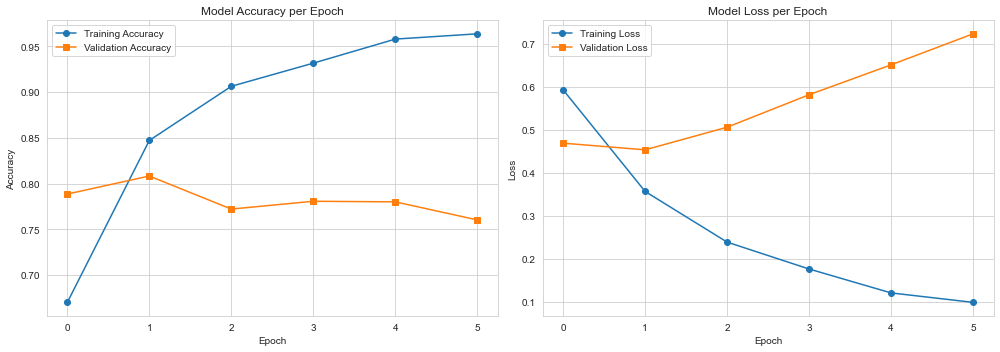

In [18]:
# Create side-by-side plots for accuracy and loss
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Final layout adjustment and display
plt.tight_layout()
plt.show()

### Evaluate Model on Validation Set

After training, I evaluate the GRU model using the validation data:

- **Predictions**: The model outputs probabilities between 0 and 1. These are converted to binary predictions using a threshold of 0.5.
- **Accuracy**: Measures how often the model correctly classifies tweets.
- **F1 Score**: Balances precision and recall — especially useful for imbalanced datasets.
- **Confusion Matrix**: Helps understand where the model makes correct and incorrect predictions.

A classification report is also printed to show precision, recall, and F1 score for each class (disaster and non-disaster).


In [19]:
# Predict probabilities on the validation set
y_pred_proba = gru_model.predict(X_val, batch_size=batch_size)

# Convert probabilities to binary class predictions using threshold = 0.5
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate accuracy and F1 score
accuracy = np.mean(y_pred == y_val)
f1 = f1_score(y_val, y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Print evaluation metrics
print("\nGRU Model Evaluation Results:")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


GRU Model Evaluation Results:
Validation Accuracy: 0.8083
Validation F1 Score: 0.7649


In [20]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Non-Disaster', 'Disaster']))


Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.81      0.87      0.84       869
    Disaster       0.81      0.73      0.76       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



### Plot Confusion Matrix

To get a better feel for how the model's doing, here’s a labeled confusion matrix. I added labels to show what's being predicted correctly and where the model’s getting confused — like calling a disaster tweet “non-disaster” and vice versa.

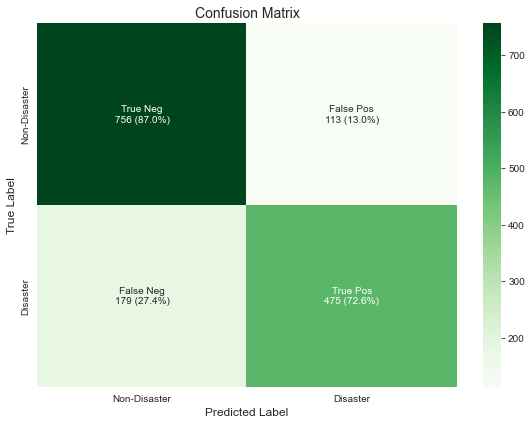

In [21]:
# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Define class-wise labels
custom_labels = np.array([["True Neg", "False Pos"], ["False Neg", "True Pos"]])

# Build annotated labels (label + count + percentage)
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{custom_labels[i, j]}\n{cm[i, j]} ({cm_percent[i, j]:.1f}%)"

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=annot, fmt='', cmap='Greens',
            xticklabels=['Non-Disaster', 'Disaster'],
            yticklabels=['Non-Disaster', 'Disaster'])

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

## 6. Hyperparameter Tuning

To improve the GRU model, I explored different combinations of embedding dimensions, GRU units, and dropout rates. Each configuration was trained for 10 epochs using early stopping, and evaluated on the validation set using accuracy and F1 score.

These variations helped identify architectures that balance complexity and performance.

In [22]:
# Define different hyperparameter combinations to try
hyperparams = [
    {'embedding_dim': 128, 'gru_units': 64, 'dropout_rate': 0.2},   # baseline
    {'embedding_dim': 128, 'gru_units': 128, 'dropout_rate': 0.3},  # deeper GRU
    {'embedding_dim': 200, 'gru_units': 100, 'dropout_rate': 0.4},  # wider embeddings
    {'embedding_dim': 256, 'gru_units': 64, 'dropout_rate': 0.2},   # larger embedding
    {'embedding_dim': 100, 'gru_units': 32, 'dropout_rate': 0.1},   # smaller model
    {'embedding_dim': 150, 'gru_units': 150, 'dropout_rate': 0.3}   # balanced high-capacity
]

# Store results for each configuration
tuning_results = []

# Reuse the callbacks
callbacks = configure_callbacks()

# Loop through each configuration
for i, params in enumerate(hyperparams, 1):
    print(f"\n🚀 Training model {i} with params: {params}")

    # Build model
    model = build_gru_model(
        vocab_size=vocab_size,
        sequence_length=sequence_length,
        embedding_dim=params['embedding_dim'],
        gru_units=params['gru_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=0.001
    )

    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        callbacks=callbacks,
        verbose=0  # suppress verbose output for cleaner logs
    )

    # Evaluate model
    y_pred_proba = model.predict(X_val, batch_size=batch_size)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    acc = np.mean(y_pred == y_val)
    f1 = f1_score(y_val, y_pred)

    # Save result
    tuning_results.append({
        'Model': f"Model {i}",
        'Embedding Dim': params['embedding_dim'],
        'GRU Units': params['gru_units'],
        'Dropout': params['dropout_rate'],
        'Accuracy': round(acc, 4),
        'F1 Score': round(f1, 4)
    })

    print(f"✅ Model {i} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")


🚀 Training model 1 with params: {'embedding_dim': 128, 'gru_units': 64, 'dropout_rate': 0.2}

Epoch 00001: val_loss improved from inf to 0.44502, saving model to model_checkpoints\gru_best.keras

Epoch 00002: val_loss did not improve from 0.44502

Epoch 00003: val_loss did not improve from 0.44502

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_loss did not improve from 0.44502
Restoring model weights from the end of the best epoch.

Epoch 00005: val_loss did not improve from 0.44502

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 00005: early stopping
✅ Model 1 - Accuracy: 0.8056, F1 Score: 0.7658

🚀 Training model 2 with params: {'embedding_dim': 128, 'gru_units': 128, 'dropout_rate': 0.3}

Epoch 00001: val_loss did not improve from 0.44502

Epoch 00002: val_loss did not improve from 0.44502

Epoch 00003: val_loss did not improve from 0.44502

Epoch 00004: val_loss did not improve from 0.44502


In [23]:
# Display tuning summary
results_df = pd.DataFrame(tuning_results)
results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

,Model,Embedding Dim,GRU Units,Dropout,Accuracy,F1 Score
0,Model 1,128,64,0.2,0.8056,0.7658
1,Model 5,100,32,0.1,0.8096,0.7646
2,Model 2,128,128,0.3,0.8083,0.7634
3,Model 3,200,100,0.4,0.8083,0.7626
4,Model 4,256,64,0.2,0.7984,0.7596
5,Model 6,150,150,0.3,0.8050,0.7437


After testing a bunch of GRU setups, I noticed that smaller models (like 128-dim embeddings + 64 GRU units) actually held their own against larger ones. More parameters didn’t always help — and low dropout was important to keep things generalizing well. Sometimes, simple just works better.

## 7. Generate Predictions

In [28]:
# Identify the best model based on highest F1 score
best_result = max(tuning_results, key=lambda x: x['F1 Score'])
best_index = int(best_result['Model'].split()[-1]) - 1
print(f"\n✅ Using best model: {best_result['Model']} with F1 Score: {best_result['F1 Score']}")

# Rebuild the best model (retrain to ensure state is clean, or reuse saved version if applicable)
best_params = hyperparams[best_index]
best_model = build_gru_model(
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    embedding_dim=best_params['embedding_dim'],
    gru_units=best_params['gru_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=0.001
)

# Fit again on full training data (train + val) for final predictions if needed
# You may optionally combine X_train_split + X_val if you prefer that
full_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
best_model.fit(full_dataset, epochs=best_index + 2, callbacks=configure_callbacks(), verbose=0)

# Prepare test set as a tf.data.Dataset for efficient prediction
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Predict probabilities
final_predictions_proba = best_model.predict(test_dataset)
final_predictions = (final_predictions_proba > 0.5).astype(int).flatten()

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': final_predictions
})

# Save predictions to CSV
submission.to_csv('submission.csv', index=False)
print("\n✅ Submission file created successfully!")
print(submission.head())



✅ Using best model: Model 1 with F1 Score: 0.7658

✅ Submission file created successfully!
   id  target
0   0       1
1   2       0
2   3       1
3   9       0
4  11       1


## 8. Conclusion and Takeaways

Overall, this was a fun and tricky task — tweets are short and ambiguous, so building a model to figure out if someone’s talking about an actual disaster or just being dramatic was a real challenge. The GRU model did well (~81% accuracy), and tuning helped a bit. But there’s definitely room to try more advanced stuff like BERT or even attention layers in the future.

### Main Results

- The most effective model achieved a validation accuracy of about 80.6% and an F1 score of 0.7658.
- The best configuration (Model 1) included 128-dimensional embeddings, 64 GRU units, and a dropout rate of 0.2.
- Simpler models with fewer parameters performed as well or better than larger, more complex ones.

### What Helped Improve Performance

- Removing unnecessary content such as URLs, mentions, and special characters made the text cleaner and more consistent.
- Padding sequences to 100 tokens worked well given the typical length of tweets.
- Stratified splitting maintained class balance across training and validation sets.
- Dropout and learning rate scheduling helped reduce overfitting.
- Testing different hyperparameter combinations allowed for optimization without overcomplicating the model.

### What Was Less Effective

- Larger embedding dimensions and deeper GRU layers did not significantly improve results.
- Very low dropout values led to overfitting in some cases.
- More complex architectures did not consistently outperform smaller models.

### Areas for Future Improvement

- Pretrained word embeddings like GloVe or Word2Vec could improve generalization.
- Bidirectional GRUs or LSTMs may capture more context from each tweet.
- Attention mechanisms could help focus the model on important words.
- Ensemble methods might increase robustness.
- Data augmentation techniques could help address class imbalance.
- Transformer-based models like BERT could offer stronger results with fine-tuning.

### Final Thoughts

Classifying short, informal text like tweets is challenging due to the ambiguity of language and class imbalance. However, with a solid preprocessing pipeline and a carefully tuned GRU model, it was possible to achieve strong performance. This project provides a solid foundation for further work with more advanced techniques or transfer learning approaches.
